<a href="https://colab.research.google.com/github/GUNAPILLCO/CEIA-GdP/blob/main/3_Desarrollo/2_obtencion_preparacion_exploracion_datos/2_4_1_hipotesis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.4.1. Hipótesis 1: Continuación del Momentum Intradía

## 1. Importación de Librerías

In [8]:
# Utilidades generales
from datetime import datetime, timedelta
import os
import glob
import requests
import warnings
warnings.filterwarnings('ignore')

# Manejo y procesamiento de datos
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
# Calendario de mercados
#import pandas_market_calendars as mcal

## 2. Carga del dataset mnq_intraday_data

In [9]:
def load_df():
    """
    Función para cargar un archivo Parquet desde una URL de GitHub, procesarlo y devolver un DataFrame.
    """
    # Definir la URL del archivo Parquet en GitHub
    url = 'https://raw.githubusercontent.com/GUNAPILLCO/CEIA-GdP/main/3_Desarrollo/2_obtencion_preparacion_exploracion_datos/mnq_intraday_data.parquet'

    # Descargar el archivo desde la URL
    response = requests.get(url)

    # Verificar si la descarga fue exitosa
    if response.status_code != 200:
        raise Exception(f"Error al descargar el archivo: {response.status_code}")

    # Guardar el archivo descargado en el entorno de Colab
    file_path = '/content/mnq_intraday_data.parquet'
    with open(file_path, 'wb') as f:
        f.write(response.content)

    # Leer el archivo Parquet y cargarlo en un DataFrame
    df = pd.read_parquet(file_path)

    # Asegurar que el índice esté en formato datetime
    df.index = pd.to_datetime(df.index)

    # Crear una nueva columna 'date' con la fecha extraída del índice
    df['date'] = df.index.date

    return df

In [10]:
mnq_intraday = load_df()

## 3. Hipótesis 1: Continuación del Momentum Intradía

**"Si el precio ha subido de forma constante en los últimos N minutos, es probable que continúe subiendo en los próximos minutos."**
<br><br>
**Justificación técnica:** <br>
Basada en la idea de momentum. Los traders tienden a subirse a la ola cuando ven un movimiento fuerte, generando continuación.
<br><br>
**Alpha Factor sugerido:** <br>Se define un factor de momentum como la diferencia entre los logaritmos del precio de cierre actual y el precio de cierre hace `N` minutos:

$$
\text{momentum}_t^{(N)} = \log(\text{close}_t) - \log(\text{close}_{t-N})
$$

Este valor puede interpretarse como el retorno logarítmico acumulado en los últimos `N` minutos. Valores positivos indican tendencia alcista reciente, mientras que valores negativos reflejan presión bajista.

**Parámetros recomendados para N:**  
- Corto plazo: `N = 5`
- Medio plazo: `N = 15`
- Largo plazo intradía: `N = 30`

**Aplicación:**

Este factor puede utilizarse como variable predictora en modelos supervisados, o directamente para generar señales de trading (ej: entrar en largo cuando Momentum > 0).

In [11]:
mnq_intraday.head()

,open,high,low,close,volume,date
datetime,,,,,,
2019-12-23 08:30:00-05:00,8736.25,8737.50,8736.25,8737.00,30,2019-12-23
2019-12-23 08:31:00-05:00,8737.00,8737.25,8736.00,8736.50,45,2019-12-23
2019-12-23 08:32:00-05:00,8736.50,8736.75,8735.50,8736.00,73,2019-12-23
2019-12-23 08:33:00-05:00,8736.50,8736.75,8736.00,8736.75,51,2019-12-23
2019-12-23 08:34:00-05:00,8736.75,8739.00,8736.75,8737.75,91,2019-12-23


## 4. Construcción de alpha factor

In [12]:
# 1. Construir alpha_factor
# Añadimos el momentum para 5, 15 y 30 minutos.
mnq_intraday['momentum_5'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x) - np.log(x.shift(5)))
mnq_intraday['momentum_15'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x) - np.log(x.shift(15)))
mnq_intraday['momentum_30'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x) - np.log(x.shift(30)))

#Esto lo vamos a aplicar por día para evitar "mezclar" información entre jornadas.

# 2. Normalizar el factor
# Para evitar que valores extremos distorsionen la interpretación y para que sea comparable entre días, normalizamos por día (por ejemplo, con z-score):

mnq_intraday['momentum_z_5'] = mnq_intraday.groupby('date')['momentum_5'].transform(lambda x: (x - x.mean()) / x.std())
mnq_intraday['momentum_z_15'] = mnq_intraday.groupby('date')['momentum_15'].transform(lambda x: (x - x.mean()) / x.std())
mnq_intraday['momentum_z_30'] = mnq_intraday.groupby('date')['momentum_30'].transform(lambda x: (x - x.mean()) / x.std())

# 3. Evaluar el poder predictivo
# Usamos una métrica como el Information Coefficient (IC): Correlación entre el valor del alpha factor y el retorno futuro.
# Definimos el retorno futuro:

mnq_intraday['target_return_5'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-5)) - np.log(x))
mnq_intraday['target_return_15'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-15)) - np.log(x))
mnq_intraday['target_return_30'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-30)) - np.log(x))

# 4. Evaluamos el IC por día para cada ventana de tiempo
# Evaluamos la correlación entre el factor y el target

ic_by_day_5 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['momentum_z_5'].corr(x['target_return_5']))

ic_by_day_15 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['momentum_z_15'].corr(x['target_return_15']))

ic_by_day_30 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['momentum_z_30'].corr(x['target_return_30']))

# Promedio del IC para cada ventana
mean_ic_5 = ic_by_day_5.mean()
mean_ic_15 = ic_by_day_15.mean()
mean_ic_30 = ic_by_day_30.mean()

# Mostrar los resultados
print(f"Mean IC (Momentum 5 min):  {mean_ic_5:.4f}")
print(f"Mean IC (Momentum 15 min): {mean_ic_15:.4f}")
print(f"Mean IC (Momentum 30 min): {mean_ic_30:.4f}")

Mean IC (Momentum 5 min):  -0.0308
Mean IC (Momentum 15 min): -0.0593
Mean IC (Momentum 30 min): -0.1094


1. La hipótesis original no se valida.

    - El IC es negativo en todas las ventanas, lo que contradice la idea de "continuación de la tendencia".
    - De hecho: A mayor ventana (N), más negativo se vuelve el IC, lo que indica una mayor probabilidad de reversión cuando el momentum es fuerte.

2. Se sugiere comportamiento de Mean Reversion.

    - Este patrón es típico en mercados de alta frecuencia como MNQ, donde los movimientos rápidos suelen agotarse y dar paso a correcciones.
    - Cuanto más largo el período de momentum (30 minutos), más fuerte la señal de reversión.

### 4.1. Replanteo de hipotesis

Hipótesis alternativa: **Si el precio subió mucho en los últimos N minutos, es probable que revierta (baje).**

In [ ]:
# 2. Normalizar el factor (pero invirtiendo el signo)
# Esto transforma la hipótesis en reversión: si subió mucho, va a bajar.

mnq_intraday['momentum_z_5'] = mnq_intraday.groupby('date')['momentum_5'].transform(
    lambda x: -(x - x.mean()) / x.std()
)
mnq_intraday['momentum_z_15'] = mnq_intraday.groupby('date')['momentum_15'].transform(
    lambda x: -(x - x.mean()) / x.std()
)
mnq_intraday['momentum_z_30'] = mnq_intraday.groupby('date')['momentum_30'].transform(
    lambda x: -(x - x.mean()) / x.std()
)

## 5. Comportamiento del alpha factor por minutos del día

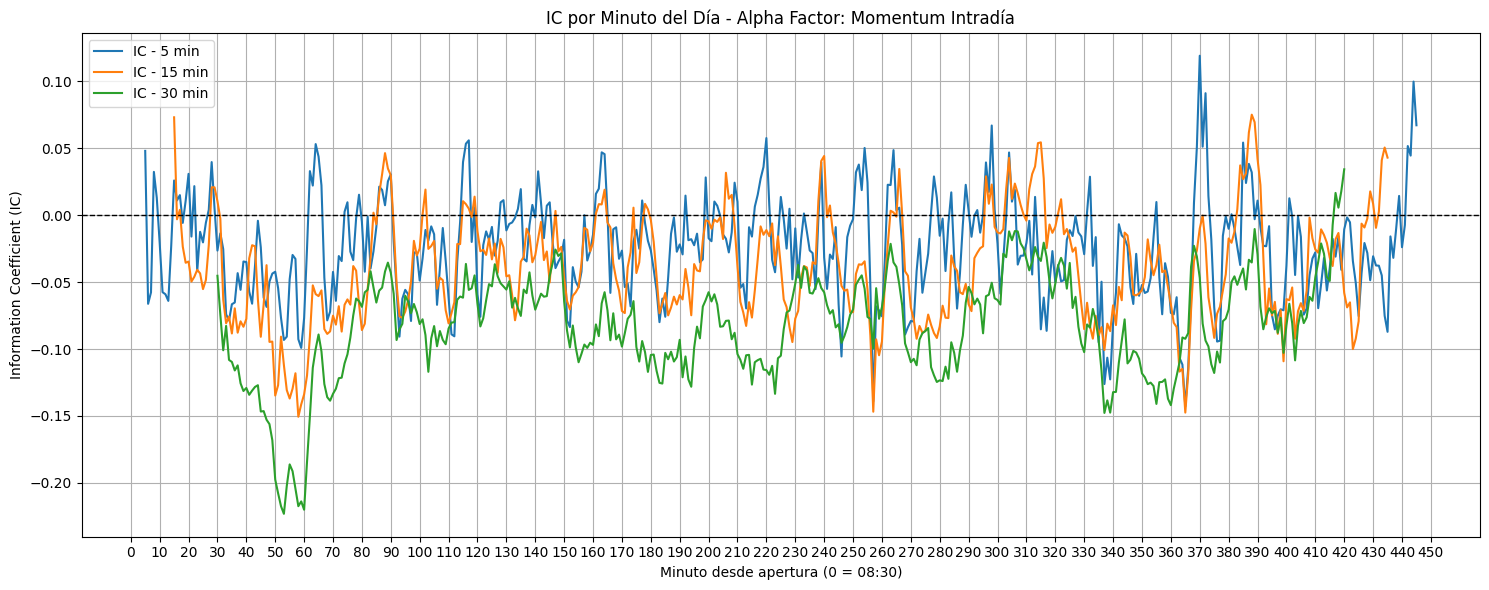

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Asegurarse de tener un identificador de fila por jornada (0 a 450)
mnq_intraday['minute_index'] = mnq_intraday.groupby('date').cumcount()

# Función para calcular IC por minuto
def compute_ic_by_minute(factor_col, target_col):
    grouped = mnq_intraday[[factor_col, target_col, 'minute_index']].dropna()
    ic_by_minute = grouped.groupby('minute_index').apply(
        lambda x: x[factor_col].corr(x[target_col])
    )
    return ic_by_minute

# Calcular IC por minuto para cada ventana temporal
ic_minute_5 = compute_ic_by_minute('momentum_z_5', 'target_return_5')
ic_minute_15 = compute_ic_by_minute('momentum_z_15', 'target_return_15')
ic_minute_30 = compute_ic_by_minute('momentum_z_30', 'target_return_30')


# Visualización
plt.figure(figsize=(15, 6))
plt.xticks(np.arange(0, 451, 10))
plt.plot(ic_minute_5.index, ic_minute_5, label='IC - 5 min')
plt.plot(ic_minute_15.index, ic_minute_15, label='IC - 15 min')
plt.plot(ic_minute_30.index, ic_minute_30, label='IC - 30 min')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('IC por Minuto del Día - Alpha Factor: Momentum Intradía')
plt.xlabel('Minuto desde apertura (0 = 08:30)')
plt.ylabel('Information Coefficient (IC)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
def analyze_intraday_ic_extremes(ic_minute_df: pd.DataFrame) -> pd.DataFrame:
    """
    Analiza series de Information Coefficient (IC) minuto a minuto para distintos alpha factors.
    Retorna un resumen con el peor IC, el minuto donde ocurre y el promedio de los 30 peores ICs.

    Parámetros:
    - ic_minute_df: DataFrame con columnas = alpha factors, índice = minuto (0 a 450)

    Retorna:
    - DataFrame resumen ordenado por el promedio de los 30 peores ICs
    """
    results = []

    for col in ic_minute_df.columns:
        series = ic_minute_df[col].dropna()
        min_ic = series.min()
        min_minute = series.idxmin()
        mean_worst_30 = series.nsmallest(30).mean()

        results.append({
            'Alpha Factor': col,
            'IC mínimo': min_ic,
            'Minuto del IC mínimo': min_minute,
            'Promedio de los 30 peores ICs': mean_worst_30
        })

    result_df = pd.DataFrame(results).set_index('Alpha Factor')
    result_df = result_df.sort_values('Promedio de los 30 peores ICs')
    return result_df

In [19]:
# Tenemos ic_minute_5, ic_minute_15, ic_minute_30
ic_minute_df = pd.DataFrame({
    'IC_momentum_5': ic_minute_5,
    'IC_momentum_15': ic_minute_15,
    'IC_momentum_30': ic_minute_30
})

analyze_intraday_ic_extremes(ic_minute_df)

,IC mínimo,Minuto del IC mínimo,Promedio de los 30 peores ICs
Alpha Factor,,,
IC_momentum_30,-0.223146,53,-0.168276
IC_momentum_15,-0.150600,58,-0.114207
IC_momentum_5,-0.142858,365,-0.097491


Entre las 09:10 a 09:40, tenemos el valor máximo negativo de IC-30min, y también los máximos negativos de IC-15min. Pero, en sentido negativo.

Ya que nuestra hipotesis no es validada (fue propuesta como continuiación) sino que es más una reversión, replanteamos la hipotesis inicial.


##5.  Agregar el alpha factor a dataset

Es un indicador de reversión intradía.

Tiene más poder predictivo (negativo) en los primeros 90 minutos del día.

Ya está normalizado por día, por lo tanto es comparable entre jornadas.

In [15]:
import numpy as np
import pandas as pd

def add_momentum_factor(df: pd.DataFrame, window: int = 30, price_col: str = 'close') -> pd.DataFrame:
    """
    Agrega un alpha factor de momentum normalizado (z-score) basado en log-retornos pasados,
    con una ventana deslizante por jornada.

    Este factor representa la hipótesis de continuación del momentum intradía.

    Parámetros:
    - df: DataFrame con columnas 'date' y columna de precio (por defecto 'close').
    - window: Número de minutos en el pasado para calcular el momentum (default = 30).
    - price_col: Nombre de la columna de precios (default = 'close').

    Retorna:
    - El mismo DataFrame con dos nuevas columnas:
        - 'momentum_{window}': log-retorno respecto a N minutos atrás.
        - 'momentum_z_{window}': z-score del momentum por jornada.
    """
    df = df.copy()

    momentum_col = f'momentum_{window}'
    momentum_z_col = f'momentum_z_{window}'

    # Calcular el log-retorno de cierre con N minutos de antigüedad, por día
    df[momentum_col] = df.groupby('date')[price_col].transform(
        lambda x: np.log(x) - np.log(x.shift(window))
    )

    # Normalizar el momentum (z-score) dentro de cada jornada
    df[momentum_z_col] = df.groupby('date')[momentum_col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

    return df

In [16]:
mnq_intraday = add_momentum_factor(mnq_intraday, window=30)
